# Exercise 6 - Neural Networks Learning

**NOTE: The example and sample data is being taken from the "Machine Learning course by Andrew Ng" in Coursera.**

## Introduction
In the previous exercise, you implemented feedforward propagation for neural networks and used it to predict handwritten digits with the weights we provided. In this exercise, you will implement the backpropagation algorithm
to learn the parameters for the neural network.
The provided script, ex4.m, will help you step through this exercise.

In [1]:
# initial imports
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
# imports from my models
from models.data_preprocessing import add_bias_unit
from models.logistic_regression import sigmoid

### Visualizing the data
Firstly we will load the data and display it on a 2-dimensional plot (Figure 1).

There are
5000 training examples in ex3data1.mat, where each training example is a
20 pixel by 20 pixel grayscale image of the digit. Each pixel is represented by
a floating point number indicating the grayscale intensity at that location.
The 20 by 20 grid of pixels is “unrolled” into a 400-dimensional vector. Each
of these training examples becomes a single row in our data matrix X. This
gives us a 5000 by 400 matrix X where every row is a training example for a
handwritten digit image.

In [3]:
# loading dataset
import scipy.io as sio  # sio for loading matlab file .mat
data = sio.loadmat('data/ex4data1.mat')
X = data['X']
y = data['y']
y[y==10] = 0 # mapping zeroes in y to 0

In [4]:
# setting up variables we will be using for this example
input_layer_size  = 400  # 20x20 Input Images of Digits
hidden_layer_size = 25   # 25 hidden units
num_labels = 10          # 10 labels, from 1 to 10

In [5]:
print('Loading and Visualizing Data ...')

m = X.shape[0]

print("Randomly selecting 100 data points to display")
rand_indices = np.random.choice(range(0,m), 100)
rand_samples = X[rand_indices, :]

Loading and Visualizing Data ...
Randomly selecting 100 data points to display


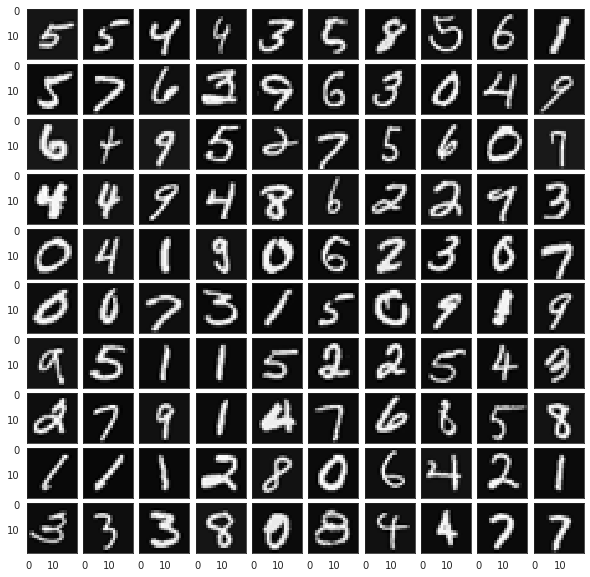

In [6]:
# displaying the 100 random samples using matplotlib
sns.set_style('white')
fig, axis = plt.subplots(10,10,sharex=True, sharey=True, figsize=(10,10))
fig.subplots_adjust(wspace=0.1, hspace=0.1)
axis_flt = axis.flatten()
for i in range(100):
    axis_flt[i].imshow(rand_samples[i, :].reshape([20,20]).T, cmap='gray')


## Model representation
Our neural network is shown in Figure 2. It has 3 layers – an input layer, a
hidden layer and an output layer. Recall that our inputs are pixel values of
digit images. Since the images are of size 20×20, this gives us 400 input layer
units (excluding the extra bias unit which always outputs +1). As before,
the training data will be loaded into the variables X and y.
You have been provided with a set of network parameters (Θ(1) , Θ(2))
already trained by us. These are stored in ex3weights.mat and will be
loaded by scipy.io into Theta1 and Theta2 The parameters have dimensions
that are sized for a neural network with 25 units in the second layer and 10
output units (corresponding to the 10 digit classes).

<img src='data/nn.jpg'>

### ================ Part 2: Loading Pameters ================
In this part of the exercise, we load some pre-initialized neural network parameters.

In [7]:
print('Loading Saved Neural Network Parameters ...')

# Load the weights into variables Theta1 and Theta2
weights = sio.loadmat('data/ex4weights.mat')
theta1 = weights['Theta1']  # theta1 = numpy array of shape 25x401
theta2 = weights['Theta2']  # theta2 = numpy array of shape 10x26

# swap first and last columns of Theta2, due to legacy from MATLAB indexing
# since the weight file ex3weights.mat was saved based on MATLAB indexing
theta2 = np.roll(theta2, 1, axis=0)

Loading Saved Neural Network Parameters ...


### ================ Part 3: Compute Cost (Feedforward) ================

For easy convenience i have made a cost function in the nural_network file in models which we will be inheriting here

In [8]:
# importing the cost function
from models.neural_network import cost_function

# joining and flattening the weights into 1D Vector for inputing in the function
nn_params = np.concatenate([theta1.flatten(), theta2.flatten()], axis=0)

In [9]:
# testing the cost function without regularization
lamda = 0
J, grad = cost_function(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lamda)

print('Cost without regularizatiion at parameters (loaded from ex4weights): {} \n(this value should be about 0.287629)\n'.format(J))

Cost without regularizatiion at parameters (loaded from ex4weights): [[0.28762917]] 
(this value should be about 0.287629)



In [10]:
# testing the cost function with regularization
lamda = 1
J, grad = cost_function(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lamda)

print('Cost without regularizatiion at parameters (loaded from ex4weights): {} \n(this value should be about 0.383770)\n'.format(J))


Cost without regularizatiion at parameters (loaded from ex4weights): [[0.38376986]] 
(this value should be about 0.383770)



### ================== Evaluating sigmoid gradient =================

Here we are testing the sigmoid_gradient function which returns the gradient of the sigmoid function evaluated at z.

For large values (both positive and negative) of z, the gradient should be close to 0. When z = 0, the gradient should be exactly 0.25

In [11]:
# generating temporary data for finding gradient
z_temp = np.array([-1, -0.5, 0, 0.5, 1])

from models.neural_network import sigmoid_gradient
g = sigmoid_gradient(z_temp)
print("Sigmoid gradient evaluated at {} is: \n {}".format(z_temp, g))

Sigmoid gradient evaluated at [-1.  -0.5  0.   0.5  1. ] is: 
 [0.19661193 0.23500371 0.25       0.23500371 0.19661193]


### ============= Initializing Parameters ================
When training neural networks, it is important to randomly initialize the parameters for symmetry breaking. One effective strategy for random initialization is to randomly select values for Θ(l) uniformly in the range [−epsilon , epsilon ]. We are using epsilon = 0.12. This range of values ensures that the parameters
are kept small and makes the learning more efficient.

In [12]:
epsilon = 0.12
initial_theta1 = np.random.uniform(-epsilon, epsilon, [hidden_layer_size, input_layer_size+1])
initial_theta2 = np.random.uniform(-epsilon, epsilon, [num_labels, hidden_layer_size+1])

# unrolling parameters
initial_nn_params = np.concatenate([initial_theta1.flatten(), initial_theta2.flatten()], axis=0)

### Implementing Backpropagation

Given a training example (x (t) , y (t) ), we will first run a “forward pass” to compute all the activations throughout the network, including the output value of the hypothesis h Θ (x). Then, for each node j in layer l, we would like to compute δ an “error term” δ that measures how much that node was “responsible” for any errors in our output.

For an output node, we can directly measure the difference between the
δ(3) network’s activation and the true target value, and use that to define δ(j)
(since layer 3 is the output layer). For the hidden units, you will compute δ(j) based on a weighted average of the error terms of the nodes in layer (l + 1).

<img src="data/back_nn.jpg">

In [13]:
from models.neural_network import check_nn_gradients, cost_function

check_nn_gradients(cost_function, 0)

[[ 1.23148991e-02  1.23148991e-02]
 [ 4.32118297e-05  4.32118324e-05]
 [-3.41523148e-04 -3.41523149e-04]
 [-5.22636696e-04 -5.22636697e-04]
 [ 3.92411900e-03  3.92411900e-03]
 [-1.85358706e-04 -1.85358706e-04]
 [-2.76203793e-05 -2.76203785e-05]
 [-4.23866853e-05 -4.23866877e-05]
 [-8.08387428e-03 -8.08387428e-03]
 [-2.44172342e-04 -2.44172343e-04]
 [ 3.11973323e-04  3.11973322e-04]
 [ 4.77620381e-04  4.77620379e-04]
 [-1.26677103e-02 -1.26677103e-02]
 [-7.80554021e-05 -7.80554002e-05]
 [ 3.64940025e-04  3.64940024e-04]
 [ 5.58582427e-04  5.58582428e-04]
 [-5.59364413e-03 -5.59364413e-03]
 [ 1.59500657e-04  1.59500657e-04]
 [ 8.20818258e-05  8.20818265e-05]
 [ 1.25696296e-04  1.25696295e-04]
 [ 3.09340815e-01  3.09340815e-01]
 [ 1.62091400e-01  1.62091400e-01]
 [ 1.46266029e-01  1.46266029e-01]
 [ 1.58240774e-01  1.58240774e-01]
 [ 1.58413849e-01  1.58413849e-01]
 [ 1.46212932e-01  1.46212932e-01]
 [ 1.08132809e-01  1.08132809e-01]
 [ 5.62398975e-02  5.62398975e-02]
 [ 5.13370615e-02  5

### Testing Regularization

To account for regularization, it turns out that you can add this as an additional term after computing the gradients using backpropagation.


In [14]:
print("Checking Backpropagation with regularization")
check_nn_gradients(cost_function, lamda=3)

Checking Backpropagation with regularization
[[ 0.01231391  0.01231391]
 [ 0.05517882  0.05517882]
 [ 0.00868734  0.00868734]
 [-0.04577885 -0.04577885]
 [ 0.00392563  0.00392563]
 [-0.01680889 -0.01680889]
 [ 0.03955839  0.03955839]
 [ 0.05947046  0.05947046]
 [-0.00808597 -0.00808597]
 [-0.03331116 -0.03331116]
 [-0.06006927 -0.06006927]
 [-0.03170477 -0.03170477]
 [-0.01266695 -0.01266695]
 [ 0.05875679  0.05875679]
 [ 0.03880249  0.03880249]
 [-0.01685445 -0.01685445]
 [-0.00559433 -0.00559433]
 [-0.04512375 -0.04512375]
 [ 0.00883054  0.00883054]
 [ 0.05474083  0.05474083]
 [ 0.30936235  0.30936235]
 [ 0.2171389   0.2171389 ]
 [ 0.15479044  0.15479044]
 [ 0.1123028   0.1123028 ]
 [ 0.10154926  0.10154926]
 [ 0.12913713  0.12913713]
 [ 0.10815189  0.10815189]
 [ 0.11588885  0.11588885]
 [ 0.07604573  0.07604573]
 [ 0.02258916  0.02258916]
 [-0.00467339 -0.00467339]
 [ 0.01909496  0.01909496]
 [ 0.10629201  0.10629201]
 [ 0.11424367  0.11424367]
 [ 0.09025339  0.09025339]
 [ 0.03670

In [28]:
### Training Neural Network

# creating short hand for cost function
c_fun = lambda p: cost_function(p, input_layer_size, hidden_layer_size, num_labels, X, y, lamda=1)

# importing scipy.optimize.minimize() function
from scipy.optimize import minimize

result = minimize(fun=c_fun, x0=initial_nn_params, jac=True, method="CG", options={'maxiter':100})

nn_params = result.x

# Obtain Theta1 and Theta2 back from nn_params
theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],
                    (hidden_layer_size, (input_layer_size + 1)))

theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):],
                    (num_labels, (hidden_layer_size + 1)))

print("the training ended with final cost of nural network = {}".format(result.fun))

the training ended with final cost of nural network = 0.35886562944784284


### Visualizing Weights

One way to understand what your neural network is learning is to visualize
what the representations captured by the hidden units. Informally, given a
particular hidden unit, one way to visualize what it computes is to find an
input x that will cause it to activate 

For the neural network you trained, notice that the i<sup>th</sup> row
of Θ (1) is a 401-dimensional vector that represents the parameter for the i<sup>th</sup>
hidden unit. If we discard the bias term, we get a 400 dimensional vector
that represents the weights from each input pixel to the hidden unit.
Thus, one way to visualize the “representation” captured by the hidden
unit is to reshape this 400 dimensional vector into a 20 × 20 image and
display it.

In our trained network, you should find that the hidden units corre-
sponds roughly to detectors that look for strokes and other patterns in the
input.


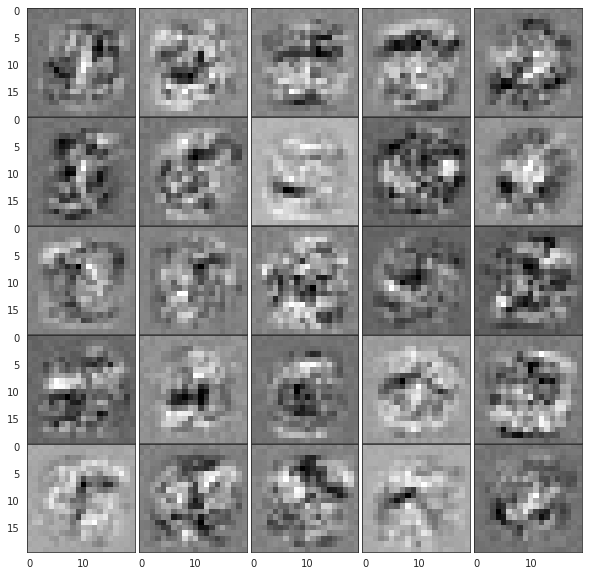

In [29]:
# displaying the 100 random samples using matplotlib
temp = theta1[:, 1:]
sns.set_style('white')
fig1, axis1 = plt.subplots(5,5,sharex=True, sharey=True, figsize=(10,10))
fig1.subplots_adjust(wspace=0.01, hspace=0.01)
axis_flt1 = axis1.flatten()
for i in range(temp.shape[0]):
    axis_flt1[i].imshow(temp[i, :].reshape([20,20]).T, cmap='gray')


### Predicting Labels with the trained model

In [42]:
h1 = sigmoid(add_bias_unit(X) @ theta1.T)
h2 = sigmoid(add_bias_unit(h1) @ theta2.T)
prediction = np.argmax(h2, axis=1).reshape(y.shape)

print("accuracy of neural network is {:.2f}%".format(np.mean(prediction==y)*100))

accuracy of neural network is 98.46%
